# Dimensionality Reduction

In [ ]:
import numpy as np
import joblib 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
import os

PROJECT_ROOT = ".." 
DIRS = {
    'data':    os.path.join(PROJECT_ROOT, 'outputs', 'data'),
    'models':  os.path.join(PROJECT_ROOT, 'outputs', 'models'),
    'figures': os.path.join(PROJECT_ROOT, 'outputs', 'figures'),
    'results': os.path.join(PROJECT_ROOT, 'outputs', 'results')
}
X_train = np.load(f"{DIRS['data']}/X_train.npy")
X_test = np.load(f"{DIRS['data']}/X_test.npy")
X_val = np.load(f"{DIRS['data']}/X_val.npy")

In [2]:
# PCA 
pca = PCA(n_components=40)
Z_pca_train = pca.fit_transform(X_train)
Z_pca_test = pca.transform(X_test)

joblib.dump(pca, f"{DIRS['models']}/pca_model.pkl")
np.save(f"{DIRS['data']}/Z_pca_train.npy", Z_pca_train)
np.save(f"{DIRS['data']}/Z_pca_test.npy", Z_pca_test)

In [3]:
# Autoencoder
class AutoEncoder(nn.Module):
  def __init__(self, input_dim, latent_dim=40):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, 1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, latent_dim)
    )
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 1024),
        nn.ReLU(),
        nn.Linear(1024, input_dim)
    )
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

ae = AutoEncoder(10304, 60)


In [6]:
epochs = 200
batch_size = 128
learning_rate = 5e-4

X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float()

train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_val_tensor)
test_dataset = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:

model = ae
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        inputs = data[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs = data[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

torch.save(model.state_dict(), f"{DIRS['models']}/autoencoder.pth")

Epoch 1/200, Train Loss: 1.0007, Val Loss: 1.0534
Epoch 2/200, Train Loss: 0.9954, Val Loss: 1.0094
Epoch 3/200, Train Loss: 0.9424, Val Loss: 0.9296
Epoch 4/200, Train Loss: 0.8802, Val Loss: 0.8882
Epoch 5/200, Train Loss: 0.8395, Val Loss: 0.8346
Epoch 6/200, Train Loss: 0.8060, Val Loss: 0.7904
Epoch 7/200, Train Loss: 0.7467, Val Loss: 0.7555
Epoch 8/200, Train Loss: 0.7145, Val Loss: 0.7247
Epoch 9/200, Train Loss: 0.6997, Val Loss: 0.7219
Epoch 10/200, Train Loss: 0.6848, Val Loss: 0.7078
Epoch 11/200, Train Loss: 0.6775, Val Loss: 0.6995
Epoch 12/200, Train Loss: 0.6676, Val Loss: 0.6922
Epoch 13/200, Train Loss: 0.6607, Val Loss: 0.6816
Epoch 14/200, Train Loss: 0.6549, Val Loss: 0.6771
Epoch 15/200, Train Loss: 0.6461, Val Loss: 0.6717
Epoch 16/200, Train Loss: 0.6425, Val Loss: 0.6642
Epoch 17/200, Train Loss: 0.6326, Val Loss: 0.6605
Epoch 18/200, Train Loss: 0.6272, Val Loss: 0.6521
Epoch 19/200, Train Loss: 0.6209, Val Loss: 0.6505
Epoch 20/200, Train Loss: 0.6127, Val Lo

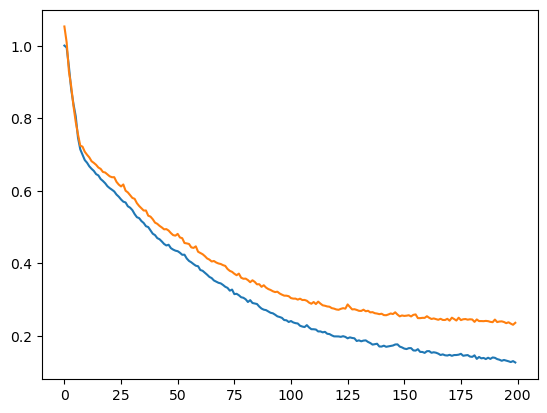

In [ ]:
model.eval()
with torch.no_grad():
    t_train = torch.FloatTensor(X_train)
    t_test = torch.FloatTensor(X_test)
    
    Z_ae_train = model.encoder(t_train).cpu().numpy()
    Z_ae_test = model.encoder(t_test).cpu().numpy()

np.save(f"{DIRS['data']}/Z_ae_train.npy", Z_ae_train)
np.save(f"{DIRS['data']}/Z_ae_test.npy", Z_ae_test)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{DIRS['figures']}/03_ae_training_loss.png", dpi=300, bbox_inches='tight')
plt.show()